In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [2]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

num train_images: 411
num val_images: 102
num test_images: 101


In [3]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

def prepare_datasets(patch_size: int, image_dims: tuple[int, int]) -> tuple[Dataset]:
    step = patch_size

    x_factor = original_dims[1] / image_dims[1]
    y_factor = original_dims[0] / image_dims[0]

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    # train_bbox_patches = []
    
    val_img_patches = []
    val_mask_patches = []
    # val_bbox_patches = []

    test_img_patches = []
    test_mask_patches = []
    # test_bbox_patches = []

    # Process train images
    i = 0
    for key in tqdm(train_images):
        # Load and resize image
        img = train_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Load and resize mask
        mask = train_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        # # Load and resize bbox
        # (x, y), w, h = train_bboxes[key]
        # bbox = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
        
        i += 1

    # Process val images
    # i = 0
    for key in tqdm(val_images):
        # Load and resize image
        img = val_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                val_img_patches.append(single_patch_img)
                # train_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = val_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                val_mask_patches.append(single_patch_mask)
                # train_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process test images
    i = 0
    for key in tqdm(test_images):
        # Load and resize image
        img = test_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                test_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = test_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)
        
        i += 1 
        
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)
    
    X_val = np.array(val_img_patches)
    Y_val = np.array(val_mask_patches)

    X_test = np.array(test_img_patches)
    Y_test = np.array(test_mask_patches)

    # Have balanced classes
    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    num_valid = len(valid_indices)
    count = 0
    for i, mask in enumerate(Y_train):
        if mask.max() == 0 and count < num_valid:
            count += 1
            valid_indices.append(i)
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_val) if mask.max() != 0]
    num_valid = len(valid_indices)
    count = 0
    for i, mask in enumerate(Y_val):
        if mask.max() == 0 and count < num_valid:
            count += 1
            valid_indices.append(i)
    X_val = X_val[valid_indices]
    Y_val = Y_val[valid_indices]
    print("X_val shape:", X_val.shape)
    print("Y_val shape:", Y_val.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
    num_valid = len(valid_indices)
    count = 0
    for i, mask in enumerate(Y_test):
        if mask.max() == 0 and count < num_valid:
            count += 1
            valid_indices.append(i)
    X_test = X_test[valid_indices]
    Y_test = Y_test[valid_indices]
    print("X_test shape:", X_test.shape)
    print("Y_test shape:", Y_test.shape)
    
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "label":  [1 if mask.max() != 0 else 0 for mask in Y_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
    }
    val_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_val],
        "label":  [1 if mask.max() != 0 else 0 for mask in Y_val],
        "mask":  [Image.fromarray(mask) for mask in Y_val],
    }
    test_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
        "label":  [1 if mask.max() != 0 else 0 for mask in Y_test],
        "mask":  [Image.fromarray(mask) for mask in Y_test],
    }
    combo_dict = {
        'image': train_dict['image'] + val_dict['image'],
        'label': train_dict['label'] + val_dict['label'],
        'mask': train_dict['mask'] + val_dict['mask'],
    }

    train_dataset = Dataset.from_dict(train_dict)
    val_dataset  = Dataset.from_dict(val_dict)
    test_dataset  = Dataset.from_dict(test_dict)
    combo_dict = Dataset.from_dict(combo_dict)
    
    return train_dataset, val_dataset, test_dataset, combo_dict

# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [11]:
patch_size = 256
image_size = 512

train_dataset, val_dataset, test_dataset, combo_dataset = prepare_datasets(patch_size, (image_size, image_size))

100%|██████████| 101/101 [00:00<00:00, 194.08it/s]


X_train shape: (840, 256, 256, 3)
Y_train shape: (840, 256, 256)
X_val shape: (210, 256, 256, 3)
Y_val shape: (210, 256, 256)
X_test shape: (216, 256, 256, 3)
Y_test shape: (216, 256, 256)


In [12]:
train_dataset, val_dataset, test_dataset, combo_dataset

(Dataset({
     features: ['image', 'label', 'mask'],
     num_rows: 840
 }),
 Dataset({
     features: ['image', 'label', 'mask'],
     num_rows: 210
 }),
 Dataset({
     features: ['image', 'label', 'mask'],
     num_rows: 216
 }),
 Dataset({
     features: ['image', 'label', 'mask'],
     num_rows: 1050
 }))

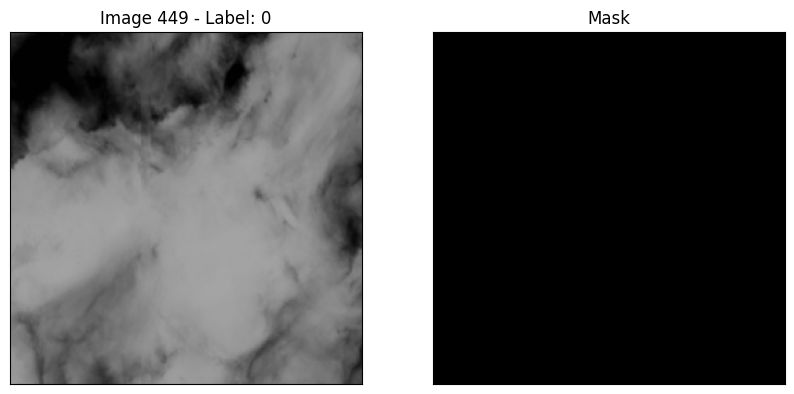

In [9]:
img_num = random.randint(0, len(train_dataset)-1)
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["mask"]
example_label = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the iamge on left
axes[0].imshow(np.array(example_image), cmap='gray')
title = f"Image {img_num} - Label: {example_label}"
axes[0].set_title(title)

# Plot the mask on right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [13]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from PIL import Image as PILImage

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

def transform(batch):
    images = [image.convert("RGB") for image in batch['image']]
    batch['pixel_values'] = [np.array(feature_extractor(images=image, return_tensors="pt")["pixel_values"][0]) for image in images]
    return batch

# train_dataset = train_dataset.map(transform, batched=True)
val_dataset = val_dataset.map(transform, batched=True)
test_dataset = test_dataset.map(transform, batched=True)
combo_dataset = combo_dataset.map(transform, batched=True)

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Map: 100%|██████████| 1050/1050 [00:25<00:00, 41.63 examples/s]


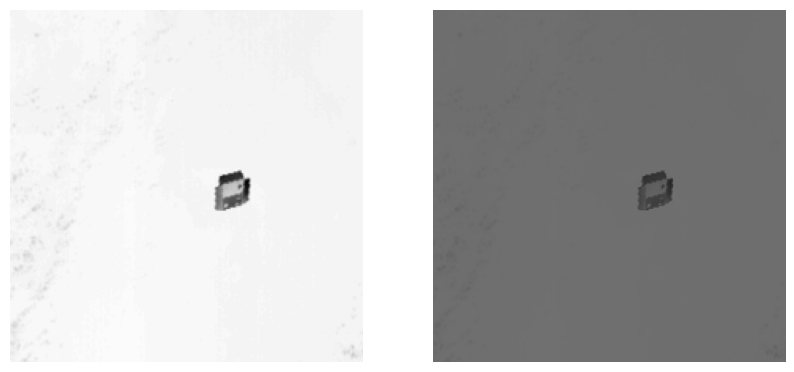

Label: 1


In [17]:
def show_image(dataset, idx):
    item = dataset[idx]
    image_tensor = np.array(item['pixel_values'])
    image = item['image']
    label = item['label']

    # Check if the tensor needs to be moved to CPU and convert it to NumPy
    if torch.cuda.is_available():
        image_np = image_tensor
    else:
        image_np = image_tensor.detach().numpy()

    # Convert to H, W, C
    image_np = image_np.transpose((1, 2, 0))

    # Denormalize image
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    plt.figure(figsize=(10, 5))

    # Display image form dataset
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis numbers and ticks

    # Display actual image
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print(f"Label: {label}")

rand_idx = random.randint(0, len(train_dataset)-1)
show_image(combo_dataset, rand_idx)

In [18]:
from sklearn.metrics import accuracy_score


model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
    ignore_mismatched_sizes=True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

best_hyperparameters = {'learning_rate': 0.0001, 'num_train_epochs': 15, 'per_device_batch_size': 16, 'weight_decay': 0.01}

training_args = TrainingArguments(
    output_dir='results/train_and_val',
    learning_rate=best_hyperparameters['learning_rate'],
    per_device_train_batch_size=best_hyperparameters['per_device_batch_size'],
    per_device_eval_batch_size=best_hyperparameters['per_device_batch_size'],
    num_train_epochs=best_hyperparameters['num_train_epochs'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Init Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combo_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                
  7%|▋         | 66/990 [01:25<12:01,  1.28it/s]

output.metrics {'eval_loss': 0.09415030479431152, 'eval_accuracy': 0.9761904761904762}
{'eval_loss': 0.09415030479431152, 'eval_accuracy': 0.9761904761904762, 'eval_runtime': 12.3152, 'eval_samples_per_second': 17.052, 'eval_steps_per_second': 1.137, 'epoch': 1.0}
metrics {'eval_loss': 0.09415030479431152, 'eval_accuracy': 0.9761904761904762, 'eval_runtime': 12.3152, 'eval_samples_per_second': 17.052, 'eval_steps_per_second': 1.137, 'epoch': 1.0}


                                                  
 13%|█▎        | 132/990 [02:31<10:39,  1.34it/s]

output.metrics {'eval_loss': 0.07752127945423126, 'eval_accuracy': 0.9857142857142858}
{'eval_loss': 0.07752127945423126, 'eval_accuracy': 0.9857142857142858, 'eval_runtime': 10.5714, 'eval_samples_per_second': 19.865, 'eval_steps_per_second': 1.324, 'epoch': 2.0}
metrics {'eval_loss': 0.07752127945423126, 'eval_accuracy': 0.9857142857142858, 'eval_runtime': 10.5714, 'eval_samples_per_second': 19.865, 'eval_steps_per_second': 1.324, 'epoch': 2.0}


                                                 
 20%|██        | 198/990 [03:38<10:00,  1.32it/s]

output.metrics {'eval_loss': 0.035040371119976044, 'eval_accuracy': 0.9952380952380953}
{'eval_loss': 0.035040371119976044, 'eval_accuracy': 0.9952380952380953, 'eval_runtime': 10.8112, 'eval_samples_per_second': 19.424, 'eval_steps_per_second': 1.295, 'epoch': 3.0}
metrics {'eval_loss': 0.035040371119976044, 'eval_accuracy': 0.9952380952380953, 'eval_runtime': 10.8112, 'eval_samples_per_second': 19.424, 'eval_steps_per_second': 1.295, 'epoch': 3.0}


                                                 
 27%|██▋       | 264/990 [04:44<09:04,  1.33it/s]

output.metrics {'eval_loss': 0.04622640088200569, 'eval_accuracy': 0.9904761904761905}
{'eval_loss': 0.04622640088200569, 'eval_accuracy': 0.9904761904761905, 'eval_runtime': 10.5449, 'eval_samples_per_second': 19.915, 'eval_steps_per_second': 1.328, 'epoch': 4.0}
metrics {'eval_loss': 0.04622640088200569, 'eval_accuracy': 0.9904761904761905, 'eval_runtime': 10.5449, 'eval_samples_per_second': 19.915, 'eval_steps_per_second': 1.328, 'epoch': 4.0}


                                                 
 33%|███▎      | 330/990 [05:51<08:07,  1.35it/s]

output.metrics {'eval_loss': 0.03283708542585373, 'eval_accuracy': 0.9952380952380953}
{'eval_loss': 0.03283708542585373, 'eval_accuracy': 0.9952380952380953, 'eval_runtime': 10.8812, 'eval_samples_per_second': 19.299, 'eval_steps_per_second': 1.287, 'epoch': 5.0}
metrics {'eval_loss': 0.03283708542585373, 'eval_accuracy': 0.9952380952380953, 'eval_runtime': 10.8812, 'eval_samples_per_second': 19.299, 'eval_steps_per_second': 1.287, 'epoch': 5.0}


                                                 
 40%|████      | 396/990 [07:09<07:11,  1.38it/s]

output.metrics {'eval_loss': 0.007968131452798843, 'eval_accuracy': 1.0}
{'eval_loss': 0.007968131452798843, 'eval_accuracy': 1.0, 'eval_runtime': 13.139, 'eval_samples_per_second': 15.983, 'eval_steps_per_second': 1.066, 'epoch': 6.0}
metrics {'eval_loss': 0.007968131452798843, 'eval_accuracy': 1.0, 'eval_runtime': 13.139, 'eval_samples_per_second': 15.983, 'eval_steps_per_second': 1.066, 'epoch': 6.0}


                                                 
 47%|████▋     | 462/990 [08:35<06:39,  1.32it/s]

output.metrics {'eval_loss': 0.029267754405736923, 'eval_accuracy': 0.9904761904761905}
{'eval_loss': 0.029267754405736923, 'eval_accuracy': 0.9904761904761905, 'eval_runtime': 11.8359, 'eval_samples_per_second': 17.743, 'eval_steps_per_second': 1.183, 'epoch': 7.0}
metrics {'eval_loss': 0.029267754405736923, 'eval_accuracy': 0.9904761904761905, 'eval_runtime': 11.8359, 'eval_samples_per_second': 17.743, 'eval_steps_per_second': 1.183, 'epoch': 7.0}


 51%|█████     | 500/990 [09:08<06:48,  1.20it/s]

{'loss': 0.1077, 'learning_rate': 4.94949494949495e-05, 'epoch': 7.58}


                                                 
 53%|█████▎    | 528/990 [09:41<06:05,  1.26it/s]

output.metrics {'eval_loss': 0.03274260833859444, 'eval_accuracy': 0.9952380952380953}
{'eval_loss': 0.03274260833859444, 'eval_accuracy': 0.9952380952380953, 'eval_runtime': 10.5616, 'eval_samples_per_second': 19.883, 'eval_steps_per_second': 1.326, 'epoch': 8.0}
metrics {'eval_loss': 0.03274260833859444, 'eval_accuracy': 0.9952380952380953, 'eval_runtime': 10.5616, 'eval_samples_per_second': 19.883, 'eval_steps_per_second': 1.326, 'epoch': 8.0}


                                                 
 60%|██████    | 594/990 [10:57<04:51,  1.36it/s]

output.metrics {'eval_loss': 0.005024946294724941, 'eval_accuracy': 1.0}
{'eval_loss': 0.005024946294724941, 'eval_accuracy': 1.0, 'eval_runtime': 13.0801, 'eval_samples_per_second': 16.055, 'eval_steps_per_second': 1.07, 'epoch': 9.0}
metrics {'eval_loss': 0.005024946294724941, 'eval_accuracy': 1.0, 'eval_runtime': 13.0801, 'eval_samples_per_second': 16.055, 'eval_steps_per_second': 1.07, 'epoch': 9.0}


                                                 
 67%|██████▋   | 660/990 [12:24<05:34,  1.02s/it]

output.metrics {'eval_loss': 0.003304045647382736, 'eval_accuracy': 1.0}
{'eval_loss': 0.003304045647382736, 'eval_accuracy': 1.0, 'eval_runtime': 13.4492, 'eval_samples_per_second': 15.614, 'eval_steps_per_second': 1.041, 'epoch': 10.0}
metrics {'eval_loss': 0.003304045647382736, 'eval_accuracy': 1.0, 'eval_runtime': 13.4492, 'eval_samples_per_second': 15.614, 'eval_steps_per_second': 1.041, 'epoch': 10.0}


                                                 
 73%|███████▎  | 726/990 [13:45<03:30,  1.25it/s]

output.metrics {'eval_loss': 0.003630444873124361, 'eval_accuracy': 1.0}
{'eval_loss': 0.003630444873124361, 'eval_accuracy': 1.0, 'eval_runtime': 14.1954, 'eval_samples_per_second': 14.794, 'eval_steps_per_second': 0.986, 'epoch': 11.0}
metrics {'eval_loss': 0.003630444873124361, 'eval_accuracy': 1.0, 'eval_runtime': 14.1954, 'eval_samples_per_second': 14.794, 'eval_steps_per_second': 0.986, 'epoch': 11.0}


                                                 
 80%|████████  | 792/990 [15:19<02:42,  1.22it/s]

output.metrics {'eval_loss': 0.003766322508454323, 'eval_accuracy': 1.0}
{'eval_loss': 0.003766322508454323, 'eval_accuracy': 1.0, 'eval_runtime': 11.614, 'eval_samples_per_second': 18.082, 'eval_steps_per_second': 1.205, 'epoch': 12.0}
metrics {'eval_loss': 0.003766322508454323, 'eval_accuracy': 1.0, 'eval_runtime': 11.614, 'eval_samples_per_second': 18.082, 'eval_steps_per_second': 1.205, 'epoch': 12.0}


                                                 
 87%|████████▋ | 858/990 [16:30<01:50,  1.19it/s]

output.metrics {'eval_loss': 0.002844117349013686, 'eval_accuracy': 1.0}
{'eval_loss': 0.002844117349013686, 'eval_accuracy': 1.0, 'eval_runtime': 11.305, 'eval_samples_per_second': 18.576, 'eval_steps_per_second': 1.238, 'epoch': 13.0}
metrics {'eval_loss': 0.002844117349013686, 'eval_accuracy': 1.0, 'eval_runtime': 11.305, 'eval_samples_per_second': 18.576, 'eval_steps_per_second': 1.238, 'epoch': 13.0}


                                                 
 93%|█████████▎| 924/990 [18:02<00:52,  1.26it/s]

output.metrics {'eval_loss': 0.0028752447105944157, 'eval_accuracy': 1.0}
{'eval_loss': 0.0028752447105944157, 'eval_accuracy': 1.0, 'eval_runtime': 14.2188, 'eval_samples_per_second': 14.769, 'eval_steps_per_second': 0.985, 'epoch': 14.0}
metrics {'eval_loss': 0.0028752447105944157, 'eval_accuracy': 1.0, 'eval_runtime': 14.2188, 'eval_samples_per_second': 14.769, 'eval_steps_per_second': 0.985, 'epoch': 14.0}


                                                 
100%|██████████| 990/990 [19:23<00:00,  1.26it/s]

output.metrics {'eval_loss': 0.0027863956056535244, 'eval_accuracy': 1.0}
{'eval_loss': 0.0027863956056535244, 'eval_accuracy': 1.0, 'eval_runtime': 11.4934, 'eval_samples_per_second': 18.271, 'eval_steps_per_second': 1.218, 'epoch': 15.0}
metrics {'eval_loss': 0.0027863956056535244, 'eval_accuracy': 1.0, 'eval_runtime': 11.4934, 'eval_samples_per_second': 18.271, 'eval_steps_per_second': 1.218, 'epoch': 15.0}


100%|██████████| 990/990 [19:24<00:00,  1.18s/it]

{'train_runtime': 1164.6321, 'train_samples_per_second': 13.524, 'train_steps_per_second': 0.85, 'train_loss': 0.06637665238043275, 'epoch': 15.0}


TrainOutput(global_step=990, training_loss=0.06637665238043275, metrics={'train_runtime': 1164.6321, 'train_samples_per_second': 13.524, 'train_steps_per_second': 0.85, 'train_loss': 0.06637665238043275, 'epoch': 15.0})

In [ ]:
train_eval = trainer.evaluate(train_dataset)
train_eval

100%|██████████| 53/53 [00:42<00:00,  1.24it/s]

output.metrics {'eval_loss': 0.03878368064761162, 'eval_accuracy': 0.9892857142857143}


{'eval_loss': 0.03878368064761162,
 'eval_accuracy': 0.9892857142857143,
 'eval_runtime': 44.3843,
 'eval_samples_per_second': 18.926,
 'eval_steps_per_second': 1.194,
 'epoch': 15.0}

In [ ]:
val_eval = trainer.evaluate(val_dataset)
val_eval

100%|██████████| 14/14 [00:09<00:00,  1.47it/s]

output.metrics {'eval_loss': 0.08071405440568924, 'eval_accuracy': 0.9809523809523809}


{'eval_loss': 0.08071405440568924,
 'eval_accuracy': 0.9809523809523809,
 'eval_runtime': 11.0452,
 'eval_samples_per_second': 19.013,
 'eval_steps_per_second': 1.268,
 'epoch': 15.0}

In [19]:
test_eval = trainer.evaluate(test_dataset)
test_eval

100%|██████████| 14/14 [00:09<00:00,  1.42it/s]

output.metrics {'eval_loss': 0.14793556928634644, 'eval_accuracy': 0.9675925925925926}


{'eval_loss': 0.14793556928634644,
 'eval_accuracy': 0.9675925925925926,
 'eval_runtime': 11.7902,
 'eval_samples_per_second': 18.32,
 'eval_steps_per_second': 1.187,
 'epoch': 15.0}

In [22]:
# Load checkpoint
for n in [66, 132, 198, 264, 330, 396, 462, 528, 594, 660, 726, 792, 858, 924, 990]:
    model = ViTForImageClassification.from_pretrained(f'results/train_and_val/checkpoint-{n}')
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=combo_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    test_eval = trainer.evaluate(test_dataset)
    print(f"Checkpoint-{n}: {test_eval}")

100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


output.metrics {'eval_loss': 0.11103912442922592, 'eval_accuracy': 0.9675925925925926}
Checkpoint-66: {'eval_loss': 0.11103912442922592, 'eval_accuracy': 0.9675925925925926, 'eval_runtime': 12.0875, 'eval_samples_per_second': 17.87, 'eval_steps_per_second': 1.158}


100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


output.metrics {'eval_loss': 0.13346415758132935, 'eval_accuracy': 0.9583333333333334}
Checkpoint-132: {'eval_loss': 0.13346415758132935, 'eval_accuracy': 0.9583333333333334, 'eval_runtime': 11.8509, 'eval_samples_per_second': 18.226, 'eval_steps_per_second': 1.181}


100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


output.metrics {'eval_loss': 0.07633300125598907, 'eval_accuracy': 0.9768518518518519}
Checkpoint-198: {'eval_loss': 0.07633300125598907, 'eval_accuracy': 0.9768518518518519, 'eval_runtime': 11.2382, 'eval_samples_per_second': 19.22, 'eval_steps_per_second': 1.246}


100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


output.metrics {'eval_loss': 0.12600679695606232, 'eval_accuracy': 0.9722222222222222}
Checkpoint-264: {'eval_loss': 0.12600679695606232, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 11.2523, 'eval_samples_per_second': 19.196, 'eval_steps_per_second': 1.244}


100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


output.metrics {'eval_loss': 0.09294251352548599, 'eval_accuracy': 0.9768518518518519}
Checkpoint-330: {'eval_loss': 0.09294251352548599, 'eval_accuracy': 0.9768518518518519, 'eval_runtime': 11.6237, 'eval_samples_per_second': 18.583, 'eval_steps_per_second': 1.204}


100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


output.metrics {'eval_loss': 0.1554323136806488, 'eval_accuracy': 0.9629629629629629}
Checkpoint-396: {'eval_loss': 0.1554323136806488, 'eval_accuracy': 0.9629629629629629, 'eval_runtime': 11.691, 'eval_samples_per_second': 18.476, 'eval_steps_per_second': 1.198}


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


output.metrics {'eval_loss': 0.16997377574443817, 'eval_accuracy': 0.9537037037037037}
Checkpoint-462: {'eval_loss': 0.16997377574443817, 'eval_accuracy': 0.9537037037037037, 'eval_runtime': 12.2533, 'eval_samples_per_second': 17.628, 'eval_steps_per_second': 1.143}


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


output.metrics {'eval_loss': 0.21291124820709229, 'eval_accuracy': 0.9490740740740741}
Checkpoint-528: {'eval_loss': 0.21291124820709229, 'eval_accuracy': 0.9490740740740741, 'eval_runtime': 15.1753, 'eval_samples_per_second': 14.234, 'eval_steps_per_second': 0.923}


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


output.metrics {'eval_loss': 0.13749773800373077, 'eval_accuracy': 0.9675925925925926}
Checkpoint-594: {'eval_loss': 0.13749773800373077, 'eval_accuracy': 0.9675925925925926, 'eval_runtime': 14.373, 'eval_samples_per_second': 15.028, 'eval_steps_per_second': 0.974}


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


output.metrics {'eval_loss': 0.11941047012805939, 'eval_accuracy': 0.9768518518518519}
Checkpoint-660: {'eval_loss': 0.11941047012805939, 'eval_accuracy': 0.9768518518518519, 'eval_runtime': 14.6559, 'eval_samples_per_second': 14.738, 'eval_steps_per_second': 0.955}


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


output.metrics {'eval_loss': 0.12928053736686707, 'eval_accuracy': 0.9722222222222222}
Checkpoint-726: {'eval_loss': 0.12928053736686707, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 14.7402, 'eval_samples_per_second': 14.654, 'eval_steps_per_second': 0.95}


100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


output.metrics {'eval_loss': 0.14345063269138336, 'eval_accuracy': 0.9675925925925926}
Checkpoint-792: {'eval_loss': 0.14345063269138336, 'eval_accuracy': 0.9675925925925926, 'eval_runtime': 11.861, 'eval_samples_per_second': 18.211, 'eval_steps_per_second': 1.18}


100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


output.metrics {'eval_loss': 0.1441929042339325, 'eval_accuracy': 0.9675925925925926}
Checkpoint-858: {'eval_loss': 0.1441929042339325, 'eval_accuracy': 0.9675925925925926, 'eval_runtime': 11.6189, 'eval_samples_per_second': 18.59, 'eval_steps_per_second': 1.205}


100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


output.metrics {'eval_loss': 0.14906632900238037, 'eval_accuracy': 0.9675925925925926}
Checkpoint-924: {'eval_loss': 0.14906632900238037, 'eval_accuracy': 0.9675925925925926, 'eval_runtime': 12.096, 'eval_samples_per_second': 17.857, 'eval_steps_per_second': 1.157}


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]

output.metrics {'eval_loss': 0.14793556928634644, 'eval_accuracy': 0.9675925925925926}
Checkpoint-990: {'eval_loss': 0.14793556928634644, 'eval_accuracy': 0.9675925925925926, 'eval_runtime': 14.458, 'eval_samples_per_second': 14.94, 'eval_steps_per_second': 0.968}


Prediction: False
Label: 0


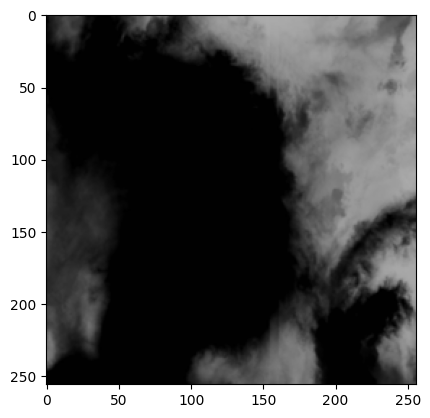

In [ ]:
# Predict on individual images
def predict_image(image: PILImage.Image) -> int:
    image_tensor = feature_extractor(images=image, return_tensors="pt")["pixel_values"].to(get_device())
    logits = model(image_tensor).logits
    prediction = logits.argmax(axis=-1)
    return bool(prediction == 1)

rand_idx = random.randint(0, len(test_dataset)-1)
# Load image from dataset
image = test_dataset[rand_idx]["image"]
prediction = predict_image(image) 
print(f"Prediction: {prediction}")
print(f"Label: {test_dataset[rand_idx]['label']}")
plt.imshow(image)
plt.show()